In [1]:
#load pandas and numpy modules
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
#read raw data
df = pd.read_csv('dataset.csv')

if df.isnull().values.any():
    print ('missing values!')
    #raise ValueError
else:
    print('pass')

df.head()

pass


,MolID,wt_A1,pore/wt_A1,D3/wt_A1,D3-pore/wt_A1,target_permeator,target1.5,BalabanJ,BertzCT,Chi0,...,PMI3,RadiusOfGyration,SpherocityIndex,avg_asphericity,avg_acylindricity,avg_kappa2,avg_rg,avg_largest_principal_rg,avg_middle_principal_rg,avg_smallest_principal_rg
0,1500272,0.875560,1.000000,1.834508,1.372092,0,0,1.429,1053.463,24.526,...,8960.40,4.71,0.26,0.377154,0.212826,0.287922,0.526401,0.505270,0.457168,0.299362
1,1501007,1.152989,1.061628,1.943367,1.755086,0,0,1.868,592.306,16.113,...,5322.33,4.43,0.13,0.310194,0.123611,0.349557,0.411174,0.391925,0.369452,0.216417
2,1501150,2.930928,1.000000,1.297877,1.143172,1,1,2.143,675.300,17.035,...,4454.32,3.82,0.13,0.307322,0.156884,0.302154,0.421545,0.403439,0.370261,0.235260
3,1503100,10.334869,1.000000,1.193855,1.049448,1,1,1.453,912.788,20.096,...,6975.32,4.50,0.21,0.402013,0.129149,0.435131,0.498724,0.478465,0.459285,0.236546
4,1503243,8.064048,1.000000,1.522722,1.344302,0,1,1.847,673.567,17.527,...,6455.60,4.67,0.11,0.365638,0.124397,0.441792,0.454138,0.437384,0.416621,0.212002


In [23]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, LeaveOneOut, ParameterGrid, cross_val_predict

RF_param_grid = {"n_estimators" : [100, 200, 400, 800],
                 "min_samples_leaf" : [1,2],
                 "max_features" : [None,'sqrt','log2']}

# RF_param_grid = {"n_estimators" : [100],
#                  "min_samples_leaf" : [1],
#                  "max_features" : ['sqrt']}

In [3]:
def grid_search_loocv(X, y, estimator, sampler, param_grid):
    from operator import itemgetter
    cv = LeaveOneOut()
    param_combinations = ParameterGrid(param_grid)
    result_list = []
    Y_pred = np.array([])
    metric_cols=['F1','precision','recall','accuracy', 'AUC','confusion_matrix']
    print("---all combinations with score metrics---")
    print('\t'.join(metric_cols)) # title row
    # evaluate model

    for param in param_combinations:
        model = Pipeline([('over-sampling', sampler), ('clf', estimator.set_params(**param))])
        #Y_pred = cross_val_predict(estimator, X, Y, cv=cv, n_jobs=-1)
        pred_probs = cross_val_predict(model, X, Yb, cv=cv, n_jobs=-1, method='predict_proba')
        Y_pred = pred_probs.argmax(axis=1)

        # claculate metrics
        f1 = round(f1_score(y,Y_pred),3)
        prec = round(precision_score(y,Y_pred),3)
        recall = round(recall_score(y,Y_pred),3)
        acc = round(accuracy_score(y,Y_pred),3)
        AUC = round(roc_auc_score(Yb, pred_probs[:,1]),3)
        conf = confusion_matrix(y,Y_pred).tolist()
        #print(acc)
        print((f1, prec, recall, acc, AUC, conf, param))
        result_list.append((f1, prec, recall, acc, AUC, conf, param))

    top_param = max(result_list,key=itemgetter(3)) # rank by accuracy
    print("---------------------")
    print(f"tuned parameteres:{top_param}\n") # best parameters combination

    # re-produce the result with best param
    print("---leave one out validation with best parameter set---")
    final_model = Pipeline([('over-sampling', sampler), ('clf', estimator.set_params(**top_param[-1]))])
    pred_probs = cross_val_predict(final_model, X, Y, cv=cv, n_jobs=-1, method='predict_proba')
    Y_pred = pred_probs.argmax(axis=1)
    fpr, tpr, _ = roc_curve(Y,pred_probs[:,1])
    plt.plot(fpr, tpr)
    plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')
    f1 = round(f1_score(Y,Y_pred),3)
    prec = round(precision_score(Y,Y_pred),3)
    recall = round(recall_score(Y,Y_pred),3)
    acc = round(accuracy_score(Y,Y_pred),3)
    AUC = round(roc_auc_score(Y, pred_probs[:,1]),3)
    conM = confusion_matrix(Y,Y_pred).tolist()
    metric_cols=['F1','precision','recall','accuracy','AUROC','confusion_matrix']
    print(pd.DataFrame([[f1,prec,recall,acc,AUC,conM]], columns = metric_cols))
    
    return top_param[-1]

In [4]:
Ycolumn = 'target_permeator'
#Ycolumn = 'target1.5'
descriptors = ['PMI1','avg_smallest_principal_rg','NumHDonors','TPSA','avg_kappa2','avg_rg','Kappa3','NumRotatableBonds','HallKierAlpha','FpDensityMorgan2','NumHAcceptors','NumHeteroatoms','LabuteASA','NumAromaticCarbocycles','NumAromaticRings','NPR2','EState_VSA2','MaxAbsEStateIndex','NumAliphaticHeterocycles','FractionCSP3','NumAliphaticCarbocycles','MinAbsEStateIndex','MinPartialCharge','NumAromaticHeterocycles','NPR1','MaxAbsPartialCharge','MinEStateIndex','avg_acylindricity','MinAbsPartialCharge','MolLogP'] # Features after clustering

print(f"### {Ycolumn} ###")
### specify X and Y ###
Y = df[Ycolumn]
X_raw = df.iloc[:,7:]

if Y.isnull().values.any():
    print("Warning: NaN found")

X = StandardScaler().fit_transform(X_raw[descriptors])
Yb = Y.to_numpy()

print(f"#positive/negative: {sum(Yb)}/{len(Yb)-sum(Yb)}")

#resampling = KMeansSMOTE(kmeans_estimator=KMeans(n_clusters=11), cluster_balance_threshold=1,  n_jobs=-1, random_state=42)
#RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE
# result = []
# for i in range(100, 150):
#     #i=170
#     for j in range(100, 150):
        # print(f"random state: {i}/{j}")
RF = RandomForestClassifier(random_state=0)
sampler = KMeansSMOTE(kmeans_estimator=KMeans(n_clusters=9, random_state=22), k_neighbors=2, cluster_balance_threshold=0.2, n_jobs=-1, random_state=22)
    #sampler = ADASYN(random_state=0)
    #sampler = RandomOverSampler(random_state=i)

#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=0)
#accuracy balanced_accuracy top_k_accuracy average_precision f1 precision recall jaccard roc_auc
#gs = GridSearchCV(model, param_grid = RF_param_grid, cv = cv, refit=True, scoring="balanced_accuracy", n_jobs=-1, error_score=0, verbose=0)
#gs.fit(X_given, Yb)

# print("\t#RF_tuned_params =", gs.best_params_)
# print("\t#Best score:", gs.best_score_)
# means = gs.cv_results_['mean_test_score']
# stds = gs.cv_results_['std_test_score']
# params = gs.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print(f"{mean} ({stdev}) with: {param}")
top_param = {'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 100}
#top_param = grid_search_loocv(X, Yb, RF, sampler, RF_param_grid)

### target_permeator ###
#positive/negative: 20/63


In [7]:
with open("random_state_tune3.txt", 'w') as ouf:
    for line in result:
        ouf.write(str(line[0])+"\n")

In [ ]:
random state: 170
tuned parameteres:(0.5, 0.562, 0.45, 0.783, 0.625, [[56, 7], [11, 9]], {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100})

random state: 0/22
tuned parameteres:(0.514, 0.6, 0.45, 0.795, 0.656, [[57, 6], [11, 9]], {'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 100})

random state: 0/27
tuned parameteres:(0.438, 0.583, 0.35, 0.783, 0.622, [[58, 5], [13, 7]], {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100})

random state: 2/23
tuned parameteres:(0.424, 0.538, 0.35, 0.771, 0.637, [[57, 6], [13, 7]], {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100})

random state: 2/37
tuned parameteres:(0.457, 0.533, 0.4, 0.771, 0.638, [[56, 7], [12, 8]], {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100})

random state: 28/27
(0.485	0.615	0.4	0.795	0.63	 [[58	 5]	 [12	 8]]	 {'max_features': 'sqrt'	 'min_samples_leaf': 1	 'n_estimators': 100})

62/39
(0.514	0.6	0.45	0.795	0.647	 [[57	 6]	 [11	 9]]	 {'max_features': 'sqrt'	 'min_samples_leaf': 1	 'n_estimators': 100})

random state: 105/127
(0.485	0.615	0.4	0.795	0.62	 [[58	 5]	 [12	 8]]	 {'max_features': 'sqrt'	 'min_samples_leaf': 1	 'n_estimators': 100})

116/133
(0.514	0.6	0.45	0.795	0.635	 [[57	 6]	 [11	 9]]	 {'max_features': 'sqrt'	 'min_samples_leaf': 1	 'n_estimators': 100})

125/30
(0.485	0.615	0.4	0.795	0.626	 [[58	 5]	 [12	 8]]	 {'max_features': 'sqrt'	 'min_samples_leaf': 1	 'n_estimators': 100})

129/8
(0.485	0.615	0.4	0.795	0.631	 [[58	 5]	 [12	 8]]	 {'max_features': 'sqrt'	 'min_samples_leaf': 1	 'n_estimators': 100})

146/140
(0.485	0.615	0.4	0.795	0.604	 [[58	 5]	 [12	 8]]	 {'max_features': 'sqrt'	 'min_samples_leaf': 1	 'n_estimators': 100})


## leave one out

---leave one out validation with best parameter set---
      F1  precision  recall  accuracy  AUROC    confusion_matrix
0  0.514        0.6    0.45     0.795  0.656  [[57, 6], [11, 9]]


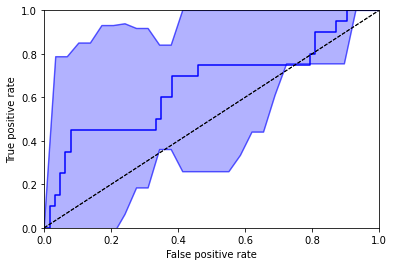

In [33]:
#sampler = KMeansSMOTE(kmeans_estimator=9, k_neighbors=2, cluster_balance_threshold=0.2)
def loocv(X, Y, hyperparam):
    #clf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features=None, random_state=3, bootstrap=True)
    cv = LeaveOneOut()
    print("---leave one out validation with best parameter set---")
    RF = RandomForestClassifier(random_state=0)
    sampler = KMeansSMOTE(kmeans_estimator=KMeans(n_clusters=9, random_state=22), k_neighbors=2, cluster_balance_threshold=0.2, n_jobs=-1, random_state=22)
    final_model = Pipeline([('over-sampling', sampler), ('clf', RF.set_params(**top_param))])
    pred_probs = cross_val_predict(final_model, X, Y, cv=cv, n_jobs=-1, method='predict_proba')
    Y_pred = pred_probs.argmax(axis=1)
    # ROC curve
    fpr, tpr, _ = roc_curve(Y,pred_probs[:,1])
    #print(len(fpr))
    plt.plot(fpr, tpr, color='b')
    plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')

    # metrics
    f1 = round(f1_score(Y,Y_pred),3)
    prec = round(precision_score(Y,Y_pred),3)
    recall = round(recall_score(Y,Y_pred),3)
    acc = round(accuracy_score(Y,Y_pred),3)
    AUC = round(roc_auc_score(Y, pred_probs[:,1]),3)
    conM = confusion_matrix(Y,Y_pred).tolist()
    metric_cols=['F1','precision','recall','accuracy','AUROC','confusion_matrix']
    print(pd.DataFrame([[f1,prec,recall,acc,AUC,conM]], columns = metric_cols))

    # confidence interval bands
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)

    metric_cols=['F1','precision','recall','accuracy','ROC_AUC','confusion_matrix']
    # results = {m:[] for m in metric_cols}
    tprs = []
    fprs = []
    for train_index, val_index in cv.split(X, Y):

        X_train, X_val, Y_train, Y_val = X[train_index], X[val_index], Y[train_index], Y[val_index]

        pred_probs = final_model.fit(X_train, Y_train).predict_proba(X_val)
        Y_pred = pred_probs.argmax(axis=1)

        fpr, tpr, _ = roc_curve(Y_val,pred_probs[:,1]) # use pred_test_probs instead of pred_test
        tprs.append(tpr)
        fprs.append(fpr)
        # results['F1'].append(round(f1_score(Y_val,Y_pred),3))
        # results['precision'].append(round(precision_score(Y_val,Y_pred),3))
        # results['recall'].append(round(recall_score(Y_val,Y_pred),3))
        # results['accuracy'].append(round(accuracy_score(Y_val,Y_pred),3))
        # results['ROC_AUC'].append(round(roc_auc_score(Y_val, pred_probs[:,1]),3))
        # results['confusion_matrix'].append(confusion_matrix(Y_val,Y_pred))

    # calculate mean and std from cross validation
    fpr_mean    = np.linspace(0, 1, 30)
    interp_tprs = []
    for i in range(5):
        fp = fprs[i]
        tp = tprs[i]
        interp_tpr = np.interp(fpr_mean, fp, tp)
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
    tpr_mean = np.mean(interp_tprs, axis=0)
    tpr_mean[-1] = 1.0
    tpr_std = 1.96*np.std(interp_tprs, axis=0)
    tpr_upper = np.clip(tpr_mean+tpr_std, 0, 1)
    tpr_lower = tpr_mean-tpr_std

    plt.plot(fpr_mean, tpr_upper, color='b', alpha=0.5)
    plt.plot(fpr_mean, tpr_lower, color='b', alpha=0.5)
    plt.fill_between(fpr_mean, tpr_upper, tpr_lower, color='b', alpha=0.3)
    plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    #plt.legend()
    plt.show()

    return

#top_param = {'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 100}
loocv(X, Yb, top_param)

In [26]:
def get_importance(X, Y, clf, hyperparam, descriptors):
    model = clf.set_params(**top_param)
    model.fit(X,Y)
    feature_importance = model.feature_importances_
    # print(descriptors)
    return pd.DataFrame({'descriptor':descriptors, 'importance':feature_importance})

print(get_importance(X, Yb, RF, top_param, descriptors))

                   descriptor  importance
0                        PMI1    0.019523
1   avg_smallest_principal_rg    0.049082
2                  NumHDonors    0.009244
3                        TPSA    0.037928
4                  avg_kappa2    0.091631
5                      avg_rg    0.049593
6                      Kappa3    0.032022
7           NumRotatableBonds    0.015488
8               HallKierAlpha    0.050696
9            FpDensityMorgan2    0.039254
10              NumHAcceptors    0.013159
11             NumHeteroatoms    0.012351
12                  LabuteASA    0.035164
13     NumAromaticCarbocycles    0.009826
14           NumAromaticRings    0.020849
15                       NPR2    0.026454
16                EState_VSA2    0.032046
17          MaxAbsEStateIndex    0.039737
18   NumAliphaticHeterocycles    0.008573
19               FractionCSP3    0.029630
20    NumAliphaticCarbocycles    0.002545
21          MinAbsEStateIndex    0.039895
22           MinPartialCharge    0

## 5-fold cross-validation

---leave one out validation with best parameter set---
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
No handles with labels found to put in legend.


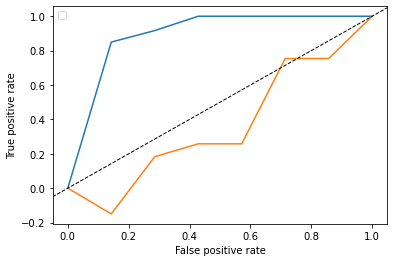

,F1,precision,recall,accuracy,ROC_AUC,confusion_matrix
0,0.667,0.600,0.75,0.824,0.846,"[[11, 2], [1, 3]]"
1,0.667,1.000,0.50,0.882,0.827,"[[13, 0], [2, 2]]"
2,0.400,0.333,0.50,0.647,0.615,"[[9, 4], [2, 2]]"
3,0.000,0.000,0.00,0.688,0.521,"[[11, 1], [4, 0]]"
4,0.000,0.000,0.00,0.625,0.562,"[[10, 2], [4, 0]]"
5,0.333,0.500,0.25,0.765,0.808,"[[12, 1], [3, 1]]"
6,0.000,0.000,0.00,0.765,0.481,"[[13, 0], [4, 0]]"
7,0.000,0.000,0.00,0.529,0.269,"[[9, 4], [4, 0]]"
8,0.400,0.333,0.50,0.625,0.521,"[[8, 4], [2, 2]]"
9,0.571,0.667,0.50,0.812,0.875,"[[11, 1], [2, 2]]"


In [27]:
def KfoldCV(X, Y, hyperparam):
    #clf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features=None, random_state=3, bootstrap=True)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
    RF = RandomForestClassifier(random_state=0)
    sampler = KMeansSMOTE(kmeans_estimator=KMeans(n_clusters=9, random_state=22), k_neighbors=2, cluster_balance_threshold=0.2, n_jobs=-1, random_state=22)
    final_model = Pipeline([('over-sampling', sampler), ('clf', RF.set_params(**top_param))])
    # pred_probs = cross_val_predict(final_model, X, Y, cv=cv, n_jobs=-1, method='predict_proba')
    #f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])
    metric_cols=['F1','precision','recall','accuracy','ROC_AUC','confusion_matrix']
    results = {m:[] for m in metric_cols}
    tprs = []
    fprs = []
    i = 0
    for train_index, val_index in cv.split(X, Y):

        X_train, X_val, Y_train, Y_val = X[train_index], X[val_index], Y[train_index], Y[val_index]

        #if sampling method is used, use this to avoid warnings: clf.fit(X_train.values, y_train.values.ravel())
        #X_resampled, Y_resampled = sampler.fit_resample(X_train, Y_train)
        pred_probs = final_model.fit(X_train, Y_train).predict_proba(X_val)
        Y_pred = pred_probs.argmax(axis=1)
        #print(pred_test_probs)
        fpr, tpr, _ = roc_curve(Y_val,pred_probs[:,1]) # use pred_test_probs instead of pred_test
        tprs.append(tpr)
        fprs.append(fpr)
        results['F1'].append(round(f1_score(Y_val,Y_pred),3))
        results['precision'].append(round(precision_score(Y_val,Y_pred),3))
        results['recall'].append(round(recall_score(Y_val,Y_pred),3))
        results['accuracy'].append(round(accuracy_score(Y_val,Y_pred),3))
        results['ROC_AUC'].append(round(roc_auc_score(Y_val, pred_probs[:,1]),3))
        results['confusion_matrix'].append(confusion_matrix(Y_val,Y_pred))

        #plt.plot(fpr, tpr, label=str(i))
        i += 1 # plot ROC curve

    # confidence band
    fpr_mean    = np.linspace(0, 1, 8)
    interp_tprs = []
    for i in range(5):
        fp = fprs[i]
        tp = tprs[i]
        interp_tpr = np.interp(fpr_mean, fp, tp)
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
    tpr_mean = np.mean(interp_tprs, axis=0)
    tpr_mean[-1] = 1.0
    tpr_std = 1.96*np.std(interp_tprs, axis=0)
    tpr_upper = np.clip(tpr_mean+tpr_std, 0, 1)
    tpr_lower = tpr_mean-tpr_std

    plt.plot(fpr_mean, tpr_upper)
    plt.plot(fpr_mean, tpr_lower)
    
    plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    #plt.title(FigureTitel)
    plt.show()
    #return a dataframe consisting five metrics and confusion matrix.
    return pd.DataFrame(results)


    # # metrics
    # f1 = round(f1_score(Y,Y_pred),3)
    # prec = round(precision_score(Y,Y_pred),3)
    # recall = round(recall_score(Y,Y_pred),3)
    # acc = round(accuracy_score(Y,Y_pred),3)
    # AUC = round(roc_auc_score(Y, pred_probs[:,1]),3)
    # conM = confusion_matrix(Y,Y_pred).tolist()
    # metric_cols=['F1','precision','recall','accuracy','AUROC','confusion_matrix']
    # print(pd.DataFrame([[f1,prec,recall,acc,AUC,conM]], columns = metric_cols))
    # return

#top_param = {'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 100}
KfoldCV(X, Yb, top_param)

In [20]:
a = [1,2,3]
b = [1,2,3]
a+b

[1, 2, 3, 1, 2, 3]

In [ ]:
### wt_A1 ###
#positive/negative: 21/62

---RandomOverSampler---
	#RF_tuned_params = {'clf__max_depth': None, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__n_estimators': 160}
	#Best score: 0.6279411764705882

---SMOTE---
	#RF_tuned_params = {'clf__max_depth': 10, 'clf__max_features': None, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 1280}
	#Best score: 0.661764705882353

---BorderlineSMOTE---
	#RF_tuned_params = {'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__n_estimators': 320}
	#Best score: 0.6507352941176471

---SVMSMOTE---
	#RF_tuned_params = {'clf__max_depth': None, 'clf__max_features': None, 'clf__min_samples_leaf': 8, 'clf__n_estimators': 160}
	#Best score: 0.7117647058823529

---ADASYN---
	#RF_tuned_params = {'clf__max_depth': None, 'clf__max_features': None, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 160}
	#Best score: 0.6507352941176471

### target_permeator ###
#positive/negative: 20/63

---RandomOverSampler---
	#RF_tuned_params = {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 8, 'clf__n_estimators': 480}
	#Best score: 0.725

---SMOTE---
	#RF_tuned_params = {'clf__max_depth': 5, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__n_estimators': 640}
	#Best score: 0.6757352941176471

---BorderlineSMOTE---
	#RF_tuned_params = {'clf__max_depth': None, 'clf__max_features': None, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 960}
	#Best score: 0.6764705882352942

---SVMSMOTE---
	#RF_tuned_params = {'clf__max_depth': 10, 'clf__max_features': None, 'clf__min_samples_leaf': 8, 'clf__n_estimators': 640}
	#Best score: 0.7367647058823529

---ADASYN---
	#RF_tuned_params = {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__n_estimators': 960}
	#Best score: 0.6757352941176471